In [141]:
import redis
import json
from textblob import Word
import re
import nltk
from nltk.corpus import stopwords
import contractions
import string
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

In [142]:
r = redis.Redis(host='redis-12442.c90.us-east-1-3.ec2.cloud.redislabs.com',port=12442,password='RHFgwK2pQ2ibFUqw8zrQBHRzK29lQtDw')
keys=r.keys('*') #getting the keys of each convesation
print(len(keys))

90


In [143]:
trackerdata=[]
for i in keys: 
    temp=r[i]
    temp = temp.decode("utf-8")
    trackerdata.append(json.loads(temp)) #each conversation is saved with its events as a list and trackername
conversations=[]
for i in trackerdata:
    conversations.append(i["events"]) #extracting only the events list of each conversation
intents=set()
intentdictnew=dict()
timestamp=0 #checking the conversation in the latest timestamp for verification
latest=[]
for conv in conversations:
    if conv[0]["timestamp"]>timestamp:
        timestamp=conv[0]["timestamp"]
        latest=conv
    for i in conv:# extracting the intents from the conversations
        if i['event']=="user":
            if i['parse_data']['intent']['name'] not in intents:
                intents.add(i['parse_data']['intent']['name'])
                intentdictnew[i['parse_data']['intent']['name']]={i["text"]}
            else:
                intentdictnew[i['parse_data']['intent']['name']].add(i["text"])
#print(timestamp)
#print(latest)
for k,v in intentdictnew.items():
    print(k,":",v)



price_details : {'price detaisl', 'i want the item details', '/price_details', 'price details', 'price detaosl'}
get_item_prices : {'/get_item_prices', 'item ifno'}
get_specific_price : {'/get_specific_price', 'cost of particular item', 'particular item particular location'}
item_details : {'100185305', 'loc is 246001', '105', '607', '100035001', 'the number is 100150000', '1000350001', '10035001', 'what is 454 calendar?', 'it is 607', 'what is 4-5-4 calender?', '100140001', '100140000', '246001', 'what is 454 calender in retail?', '100150000', 'give adhipursh review'}
location_details : {'location 607', 'location 246001', 'location 105', 'loc is 607', 'price details for location 607', 'loc 607'}
hello : {'/hello'}
continue_info : {'yes', 'RMS'}
get_item_all_locs : {'cost of all items in particular location', '/get_item_all_locs', 'UPC in RMS'}
deny : {'no', 'vendor', 'what is vendor', 'i want the trichy weather', '/stop'}
greet : {'hey', 'how is the weather in trichy', 'sup', 'adipuru

In [144]:
#checking the user inputs in the latest conversation
for i in latest:
    if i["event"]=="user":
        print(i)

{'event': 'user', 'timestamp': 1687415465.6622987, 'metadata': {'model_id': '4c8c0a11c7c84b87b623395f9239c4d9', 'assistant_id': '20230421-154826-finite-valuation'}, 'text': 'what is Stock Ledger in retail domain', 'parse_data': {'intent': {'name': 'others', 'confidence': 0.6023410558700562}, 'entities': [], 'text': 'what is Stock Ledger in retail domain', 'message_id': 'e5f0827d490c4a7797c5f3a20afa0e68', 'metadata': {}, 'text_tokens': [[0, 4], [5, 7], [8, 13], [14, 20], [21, 23], [24, 30], [31, 37]], 'intent_ranking': [{'name': 'others', 'confidence': 0.6023410558700562}, {'name': 'hello', 'confidence': 0.05353327840566635}, {'name': 'others_info', 'confidence': 0.0518476627767086}, {'name': 'greet', 'confidence': 0.048821065574884415}, {'name': 'get_specific_price', 'confidence': 0.048629675060510635}, {'name': 'price_details', 'confidence': 0.031558457762002945}, {'name': 'supplier_details', 'confidence': 0.02991744503378868}, {'name': 'inventory_details', 'confidence': 0.02557235956

DESCRIPTIVE ANALYSIS OF UNRECOGNISED USER INPUTS

In [145]:
print(intentdictnew["nlu_fallback"])
print(intentdictnew["others"])
newinputs=intentdictnew["nlu_fallback"] | intentdictnew["others"]
print(newinputs)

{'/action_get_item_prices', 'prime minister of india', 'what is the weather in chennai', 'hows the weather like in chennai', 'president of india', 'list IT companies in chennai', 'list IT companies chennai', 'cheif minister of tamilnadu', 'what is the weather like', '607', 'what is replenishment ?', 'upc oracle', 'what is the weather condition in trichy', 'list states in tamilnadu', 'who is the cheoif minister of tamilnadu', 'UPC in retail', 'how is the climate', 'what is climatic change', 'what is the weather in madurai', 'how is the weather like', 'rasa', 'loc is 607', 'i want the iem details', '100035001', 'how is the climate like', 'what is the climate', 'prime minister of tamilnadu', 'what is UPC', 'UPC', 'who is vendor', 'what is the wetaher like', 'what is RASA', '100150000', 'list states in india'}
{'what is the weather like', 'what is the weather in chennai', 'what is the weather in trichy', 'what is the weather', 'hwta is UPC', 'what is RMS', 'who is the cheif minister of tam

PREPROCESSING THE DATA

In [146]:
#removing button inputs
newinputs2=set()
for i in newinputs:
    if i[0]!='/':
        newinputs2.add(i.lower())
newinputs2=list(newinputs2)
print(newinputs2)

['prime minister of india', 'what is upc', 'what is the weather in chennai', 'list it companies chennai', 'hows the weather like in chennai', 'president of india', 'what is python', 'cheif minister of tamilnadu', 'what is the weather like', '607', 'list it companies in chennai', 'what is replenishment ?', 'upc oracle', 'upc', 'what is the weather condition in trichy', 'list states in tamilnadu', 'who is the cheoif minister of tamilnadu', 'how is the climate', 'upc in retail', 'what is climatic change', 'what is the weather in madurai', 'how is the weather like', 'what is stock ledger in retail domain', 'rasa', 'loc is 607', 'what is rasa', 'i want the iem details', '100035001', 'how is the climate like', 'what is rms', 'what is the climate', 'what is the weather in trichy', 'prime minister of tamilnadu', 'what is the weather', 'who is vendor', 'what is the wetaher like', 'who is the cheif minister of tamilnadu', '100150000', 'list states in india', 'hwta is upc']


In [147]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

In [148]:
def cleaning_contractions(text):
    text=text.split()
    corrected=[]
    for word in text:
        corrected.append(contractions.fix(word))
    return " ".join(corrected)

In [149]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    return re.sub(re.compile("["+punctuations_list+"‼️’]")," ",text)

In [150]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
def cleaning_stopwords(data):
    words = data.split()
    filtered_words = [word for word in words if word not in stop_words]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\metul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [151]:
def correct_word_spelling(sentence):
    words=sentence.split()
    words2=[]
    for word in words:
        word = Word(word)
        words2.append(word.correct())
    return(" ".join(words2))

In [152]:
#performing all data cleaning operations
cleanedinputs=[]
wordmap=dict()
for i in newinputs2:
    temp=cleaning_numbers(i)
    temp=cleaning_contractions(temp)
    #temp=correct_word_spelling(temp)
    temp=cleaning_punctuations(temp)
    temp=cleaning_stopwords(temp)
    if temp!="":
        cleanedinputs.append(temp)
        keys=set(wordmap.keys())
        for j in temp.split():
            if j not in keys:
                wordmap[j]=[i]
            else:
                wordmap[j].append(i) #mapping the maps to their sentences


In [153]:
#print(wordmap)
for k,v in wordmap.items():
    print(k,":",v)

prime : ['prime minister of india', 'prime minister of tamilnadu']
minister : ['prime minister of india', 'cheif minister of tamilnadu', 'who is the cheoif minister of tamilnadu', 'prime minister of tamilnadu', 'who is the cheif minister of tamilnadu']
india : ['prime minister of india', 'president of india', 'list states in india']
upc : ['what is upc', 'upc oracle', 'upc', 'upc in retail', 'hwta is upc']
weather : ['what is the weather in chennai', 'hows the weather like in chennai', 'what is the weather like', 'what is the weather condition in trichy', 'what is the weather in madurai', 'how is the weather like', 'what is the weather in trichy', 'what is the weather']
chennai : ['what is the weather in chennai', 'list it companies chennai', 'hows the weather like in chennai', 'list it companies in chennai']
list : ['list it companies chennai', 'list it companies in chennai', 'list states in tamilnadu', 'list states in india']
companies : ['list it companies chennai', 'list it compani

In [154]:
words=[]
corpus=[] #for clustering
for i in cleanedinputs:
    words.extend(i.split())
    corpus.append(i.split())
#print(words)
wordcount=Counter(words) #counting occurance of each word
print(wordcount)
for k,v in wordcount.items():
    print (k,":",v)

Counter({'weather': 8, 'minister': 5, 'upc': 5, 'like': 5, 'tamilnadu': 5, 'chennai': 4, 'list': 4, 'india': 3, 'climate': 3, 'prime': 2, 'companies': 2, 'cheif': 2, 'trichy': 2, 'states': 2, 'retail': 2, 'rasa': 2, 'president': 1, 'python': 1, 'replenishment': 1, 'oracle': 1, 'condition': 1, 'cheoif': 1, 'climatic': 1, 'change': 1, 'madurai': 1, 'stock': 1, 'ledger': 1, 'domain': 1, 'loc': 1, 'want': 1, 'iem': 1, 'details': 1, 'rms': 1, 'vendor': 1, 'wetaher': 1, 'hwta': 1})
prime : 2
minister : 5
india : 3
upc : 5
weather : 8
chennai : 4
list : 4
companies : 2
like : 5
president : 1
python : 1
cheif : 2
tamilnadu : 5
replenishment : 1
oracle : 1
condition : 1
trichy : 2
states : 2
cheoif : 1
climate : 3
retail : 2
climatic : 1
change : 1
madurai : 1
stock : 1
ledger : 1
domain : 1
rasa : 2
loc : 1
want : 1
iem : 1
details : 1
rms : 1
vendor : 1
wetaher : 1
hwta : 1


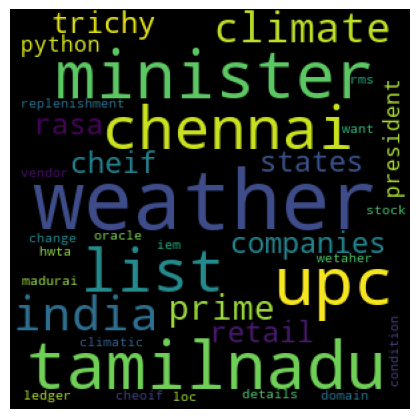

In [155]:
comment_words = " ".join(words)+ " "
#print(comment_words)
wordcloud = WordCloud(width = 300, height = 300,background_color ='black',min_font_size = 10).generate(comment_words)
plt.figure(figsize = (4, 4), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()


trying clustering

In [156]:
print(corpus)

[['prime', 'minister', 'india'], ['upc'], ['weather', 'chennai'], ['list', 'companies', 'chennai'], ['weather', 'like', 'chennai'], ['president', 'india'], ['python'], ['cheif', 'minister', 'tamilnadu'], ['weather', 'like'], ['list', 'companies', 'chennai'], ['replenishment'], ['upc', 'oracle'], ['upc'], ['weather', 'condition', 'trichy'], ['list', 'states', 'tamilnadu'], ['cheoif', 'minister', 'tamilnadu'], ['climate'], ['upc', 'retail'], ['climatic', 'change'], ['weather', 'madurai'], ['weather', 'like'], ['stock', 'ledger', 'retail', 'domain'], ['rasa'], ['loc'], ['rasa'], ['want', 'iem', 'details'], ['climate', 'like'], ['rms'], ['climate'], ['weather', 'trichy'], ['prime', 'minister', 'tamilnadu'], ['weather'], ['vendor'], ['wetaher', 'like'], ['cheif', 'minister', 'tamilnadu'], ['list', 'states', 'india'], ['hwta', 'upc']]


In [157]:
from gensim.models import Word2Vec
model = Word2Vec(corpus, vector_size=100, min_count=1)

In [158]:
from sklearn.decomposition import PCA

# fit a 2d PCA model to the vectors
vectors = model[model.wv.key_to_index]
words = list(model.wv.vocab)
pca = PCA(n_components=2)
PCA_result = pca.fit_transform(vectors)
# prepare a dataframe
words = pd.DataFrame(words)
PCA_result = pd.DataFrame(PCA_result)
PCA_result['x_values'] =PCA_result.iloc[0:, 0]
PCA_result['y_values'] =PCA_result.iloc[0:, 1]
PCA_final = pd.merge(words, PCA_result, left_index=True, right_index=True)
PCA_final['word'] =PCA_final.iloc[0:, 0]
PCA_data_complet =PCA_final[['word','x_values','y_values']]


TypeError: 'Word2Vec' object is not subscriptable

In [ ]:
import numpy as np
from sklearn.cluster import AffinityPropagation
import distance
    
words = np.asarray(words) #So that indexing with a list will work
lev_similarity = -1*np.array([[distance.levenshtein(w1,w2) for w1 in words] for w2 in words])

affprop = AffinityPropagation(affinity="precomputed", damping=0.5)
affprop.fit(lev_similarity)
for cluster_id in np.unique(affprop.labels_):
    exemplar = words[affprop.cluster_centers_indices_[cluster_id]]
    cluster = np.unique(words[np.nonzero(affprop.labels_==cluster_id)])
    #cluster_str = ", ".join(cluster)
    count=[wordcount[i] for i in cluster]
    #print(exemplar,":", cluster_str,[wordcount[i] for i in cluster])
    print(exemplar+"("+str(sum(count))+")",":",", ".join([cluster[i]+"("+str(count[i])+")" for i in range(len(cluster))]))

prime(4) : president(1), prime(2), python(1)
minister(5) : minister(5)
india(5) : condition(1), india(3), vendor(1)
weather(9) : weather(8), wetaher(1)
list(6) : iem(1), list(4), want(1)
chennai(6) : change(1), chennai(4), madurai(1)
like(5) : like(5)
cheif(3) : cheif(2), cheoif(1)
companies(2) : companies(2)
replenishment(1) : replenishment(1)
upc(5) : loc(1), upc(4)
trichy(2) : trichy(2)
states(2) : states(2)
retail(2) : details(1), retail(1)
rasa(4) : hwta(1), rasa(2), rms(1)
climate(4) : climate(3), climatic(1)
tamilnadu(5) : tamilnadu(5)


In [ ]:
for k,v in wordmap.items():
    print(k,":",v)

prime : ['prime minister of india', 'prime minister of tamilnadu']
minister : ['prime minister of india', 'cheif minister of tamilnadu', 'who is the cheoif minister of tamilnadu', 'prime minister of tamilnadu', 'who is the cheif minister of tamilnadu']
india : ['prime minister of india', 'president of india', 'list states in india']
upc : ['what is upc', 'upc', 'upc in retail', 'hwta is upc']
weather : ['what is the weather in chennai', 'hows the weather like in chennai', 'what is the weather like', 'what is the weather condition in trichy', 'what is the weather in madurai', 'how is the weather like', 'what is the weather in trichy', 'what is the weather']
chennai : ['what is the weather in chennai', 'list it companies chennai', 'hows the weather like in chennai', 'list it companies in chennai']
list : ['list it companies chennai', 'list it companies in chennai', 'list states in tamilnadu', 'list states in india']
companies : ['list it companies chennai', 'list it companies in chennai'